# Train a BERT Model with Tensorflow from Scratch

In [1]:
!pip install --upgrade pip
!pip install -q wrapt --upgrade --ignore-installed
!pip install -q tensorflow==2.1.0
!pip install -q transformers==2.8.0

Requirement already up-to-date: pip in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (20.1.1)


In [2]:
import time
import random
import pandas as pd
from glob import glob
import argparse
import json
import subprocess
import sys
import os
import tensorflow as tf
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import TextClassificationPipeline
from transformers.configuration_distilbert import DistilBertConfig

In [3]:
tf.__version__

'2.1.0'

In [4]:
MAX_SEQ_LENGTH=128
BATCH_SIZE=8
EPOCHS=1
STEPS_PER_EPOCH=250
VALIDATION_STEPS=50
TEST_STEPS=50
CLASSES = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
NUM_GPUS=0

In [5]:
def select_data_and_label_from_record(record):
    x = {
        'input_ids': record['input_ids'],
        'input_mask': record['input_mask'],
        'segment_ids': record['segment_ids']
    }
    y = record['label_ids']

    return (x, y)

In [6]:
def file_based_input_dataset_builder(channel,
                                     input_filenames,
                                     pipe_mode,
                                     is_training,
                                     drop_remainder):

    # For training, we want a lot of parallel reading and shuffling.
    # For eval, we want no shuffling and parallel reading doesn't matter.

    if pipe_mode:
        print('***** Using pipe_mode with channel {}'.format(channel))
        from sagemaker_tensorflow import PipeModeDataset
        dataset = PipeModeDataset(channel=channel,
                                  record_format='TFRecord')
    else:
        print('***** Using input_filenames {}'.format(input_filenames))
        dataset = tf.data.TFRecordDataset(input_filenames)

    dataset = dataset.repeat(EPOCHS * STEPS_PER_EPOCH)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    name_to_features = {
      "input_ids": tf.io.FixedLenFeature([MAX_SEQ_LENGTH], tf.int64),
      "input_mask": tf.io.FixedLenFeature([MAX_SEQ_LENGTH], tf.int64),
      "segment_ids": tf.io.FixedLenFeature([MAX_SEQ_LENGTH], tf.int64),
      "label_ids": tf.io.FixedLenFeature([], tf.int64),
    }

    def _decode_record(record, name_to_features):
        """Decodes a record to a TensorFlow example."""
        return tf.io.parse_single_example(record, name_to_features)
        
    dataset = dataset.apply(
        tf.data.experimental.map_and_batch(
          lambda record: _decode_record(record, name_to_features),
          batch_size=BATCH_SIZE,
          drop_remainder=drop_remainder,
          num_parallel_calls=tf.data.experimental.AUTOTUNE))

    dataset.cache()

    if is_training:
        dataset = dataset.shuffle(seed=42,
                                  buffer_size=10,
                                  reshuffle_each_iteration=True)

    return dataset

In [7]:
train_data = 'data/output/bert/train'

In [8]:
train_data_filenames = glob('{}/*.tfrecord'.format(train_data))
print('train_data_filenames {}'.format(train_data_filenames))
train_dataset = file_based_input_dataset_builder(
    channel = 'train',
    input_filenames = train_data_filenames,
    pipe_mode=False,
    is_training=True,
    drop_remainder=False).map(select_data_and_label_from_record)

train_data_filenames ['data/output/bert/train/part-unknown-tweet_file_01.tfrecord', 'data/output/bert/train/part-unknown-tweet_file_02.tfrecord']
***** Using input_filenames ['data/output/bert/train/part-unknown-tweet_file_01.tfrecord', 'data/output/bert/train/part-unknown-tweet_file_02.tfrecord']
Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


In [9]:
train_dataset

<MapDataset shapes: ({input_ids: (None, 128), input_mask: (None, 128), segment_ids: (None, 128)}, (None,)), types: ({input_ids: tf.int64, input_mask: tf.int64, segment_ids: tf.int64}, tf.int64)>

In [10]:
validation_data = 'data/output/bert/validation'

In [11]:
validation_data_filenames = glob('{}/*.tfrecord'.format(validation_data))

print('validation_data_filenames {}'.format(validation_data_filenames))
validation_dataset = file_based_input_dataset_builder(
    channel='validation',
    input_filenames=validation_data_filenames,
    pipe_mode=False,
    is_training=False,
    drop_remainder=False).map(select_data_and_label_from_record)

validation_data_filenames ['data/output/bert/validation/part-unknown-tweet_file_01.tfrecord', 'data/output/bert/validation/part-unknown-tweet_file_02.tfrecord']
***** Using input_filenames ['data/output/bert/validation/part-unknown-tweet_file_01.tfrecord', 'data/output/bert/validation/part-unknown-tweet_file_02.tfrecord']


In [12]:
test_data = 'data/output/bert/test'

In [13]:
test_data_filenames = glob('{}/*.tfrecord'.format(test_data))

print(test_data_filenames)

test_dataset = file_based_input_dataset_builder(
    channel='test',
    input_filenames=test_data_filenames,
    pipe_mode=False,
    is_training=False,
    drop_remainder=False).map(select_data_and_label_from_record)

['data/output/bert/test/part-unknown-tweet_file_01.tfrecord', 'data/output/bert/test/part-unknown-tweet_file_02.tfrecord']
***** Using input_filenames ['data/output/bert/test/part-unknown-tweet_file_01.tfrecord', 'data/output/bert/test/part-unknown-tweet_file_02.tfrecord']


In [14]:
config = DistilBertConfig.from_pretrained('distilbert-base-uncased',
                                          num_labels = len(CLASSES)
                                         )
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', config = config)

In [15]:
config

DistilBertConfig {
  "_num_labels": 10,
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "bad_words_ids": null,
  "bos_token_id": null,
  "decoder_start_token_id": null,
  "dim": 768,
  "do_sample": false,
  "dropout": 0.1,
  "early_stopping": false,
  "eos_token_id": null,
  "finetuning_task": null,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9"
  },
  "initializer_range": 0.02,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 512,
  "min_length": 0,
  "model_type": 

## Setup the Custom Classifier Model Here

In [16]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08)
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
model.layers[0].trainable = False
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
_________________________________________________________________
pre_classifier (Dense)       multiple                  590592    
_________________________________________________________________
classifier (Dense)           multiple                  7690      
_________________________________________________________________
dropout_19 (Dropout)         multiple                  0         
Total params: 66,961,162
Trainable params: 598,282
Non-trainable params: 66,362,880
_________________________________________________________________


In [17]:
print(model.layers[0])
print(model.layers[1])
print(model.layers[2])
print(model.layers[3])

In [18]:
callbacks = []

log_dir = './tensorboard/'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
callbacks.append(tensorboard_callback)

In [19]:
history = model.fit(train_dataset,
                    shuffle=True,
                    epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=validation_dataset,
                    validation_steps=VALIDATION_STEPS,
                    callbacks=callbacks)

Train for 250 steps, validate for 50 steps
250/250 [==============================] - 34s 135ms/step - loss: 2.0974 - accuracy: 0.2145 - val_loss: 2.3747 - val_accuracy: 0.5000


In [20]:
print('Trained model {}'.format(model))

Trained model <transformers.modeling_tf_distilbert.TFDistilBertForSequenceClassification object at 0x7f4659cb15f8>


## Evaluate on Holdout Test Dataset

In [21]:
test_history = model.evaluate(test_dataset, steps=TEST_STEPS, callbacks = callbacks)
print(test_history)

50/50 [==============================] - 4s 81ms/step - loss: 1.5358 - accuracy: 1.0000
[1.5357826948165894, 1.0]


## Save the Model

In [22]:
model_dir = './fine-tuned'

In [23]:
!mkdir -p $model_dir
model.save_pretrained(model_dir)

In [24]:
!ls -al $model_dir

total 261708
drwxrwxr-x 2 ec2-user ec2-user      4096 Jun 28 05:15 .
drwxrwxr-x 8 ec2-user ec2-user      4096 Jun 28 05:15 ..
-rw-rw-r-- 1 ec2-user ec2-user      1549 Jun 28 05:15 config.json
-rw-rw-r-- 1 ec2-user ec2-user 267974448 Jun 28 05:15 tf_model.h5


In [25]:
cat $model_dir/config.json

{
  "_num_labels": 10,
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "bad_words_ids": null,
  "bos_token_id": null,
  "decoder_start_token_id": null,
  "dim": 768,
  "do_sample": false,
  "dropout": 0.1,
  "early_stopping": false,
  "eos_token_id": null,
  "finetuning_task": null,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9"
  },
  "initializer_range": 0.02,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 512,
  "min_length": 0,
  "model_type": "distilbert",
  "

In [26]:
import json
from transformers import TFDistilBertForSequenceClassification

loaded_model = TFDistilBertForSequenceClassification.from_pretrained(model_dir,
                                                                     id2label={
                                                                       0: 0,
                                                                       1: 1,
                                                                       2: 2,
                                                                       3: 3,
                                                                       4: 4,
                                                                       5: 5,
                                                                       6: 6,
                                                                       7: 7,
                                                                       8: 8,
                                                                       9: 9                                                                         
                                                                     },
                                                                     label2id={
                                                                       0: 0,
                                                                       1: 1,
                                                                       2: 2,
                                                                       3: 3,
                                                                       4: 4,
                                                                       5: 5,
                                                                       6: 6,
                                                                       7: 7,
                                                                       8: 8,
                                                                       9: 9                                                                         
                                                                    })

In [27]:
loaded_model

In [28]:
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

if NUM_GPUS >= 1:
    inference_device = 0 # GPU 0
else:
    inference_device = -1 # CPU
print('inference_device {}'.format(inference_device))    

inference_device -1


In [29]:
from transformers import TextClassificationPipeline
inference_pipeline = TextClassificationPipeline(model = loaded_model,
                                                tokenizer = tokenizer,
                                                framework = 'tf',
                                                device = inference_device) # -1 is CPU, 0 is GPU

In [30]:
print("""I loved it!  I will recommend this to everyone.""", inference_pipeline("""I loved it!  I will recommend this to everyone."""))
print("""Really bad.  I hope they don't make this anymore.""", inference_pipeline("""Really bad.  I hope they don't make this anymore."""))

I loved it!  I will recommend this to everyone. [{'label': 1, 'score': 0.15191571}]
Really bad.  I hope they don't make this anymore. [{'label': 1, 'score': 0.15669052}]


## Test Model

In [31]:
train_gz_file = 'data/split/tweet_file_01.csv.gz'

In [32]:
import csv

df_sample_reviews = pd.read_csv(train_gz_file, 
                                compression='gzip')[['TWEET', 'LABEL']].sample(n=100)
print(df_sample_reviews.shape)
print(df_sample_reviews.head())


(100, 2)
                                                    TWEET  LABEL
104602  @__shaquille__ and on an even brighter side we...      3
20600                                  thank youu babee n      1
92520                               @damicogiada96 never!      1
32129        ion know if i posted this yet or not but fav      0
44963                                @thevampsjames cute!      5


In [33]:
import pandas as pd

def predict(review_body):
    prediction_map = inference_pipeline(review_body)
    return prediction_map[0]['label']

y_pred = df_sample_reviews['TWEET'].map(predict)
y_pred

104602    1
20600     1
92520     1
32129     1
44963     1
33184     1
2345      1
29801     1
36599     1
115185    1
14821     1
15081     1
91434     1
92053     1
96841     1
49052     1
14383     1
112097    1
77146     1
34675     1
63781     1
50536     1
54039     1
28591     1
20708     1
75091     1
61038     1
80651     1
114387    1
106234    1
         ..
1891      1
54890     1
23204     1
45394     1
100479    1
81531     1
103091    1
39174     1
54416     3
4820      3
98009     1
66819     1
93258     1
100091    1
113618    1
104444    1
103127    1
91849     1
3719      1
76793     1
84806     1
29118     1
102278    1
67837     1
79334     1
53686     1
29996     1
54820     1
17538     1
98028     3
Name: TWEET, Length: 100, dtype: int64

In [34]:
y_true = df_sample_reviews['LABEL']
y_true

104602    3
20600     1
92520     1
32129     0
44963     5
33184     3
2345      3
29801     7
36599     3
115185    1
14821     7
15081     4
91434     9
92053     8
96841     8
49052     3
14383     0
112097    5
77146     3
34675     2
63781     4
50536     3
54039     3
28591     7
20708     4
75091     2
61038     5
80651     3
114387    7
106234    2
         ..
1891      5
54890     7
23204     3
45394     5
100479    3
81531     4
103091    0
39174     5
54416     7
4820      4
98009     3
66819     3
93258     0
100091    5
113618    0
104444    3
103127    1
91849     3
3719      3
76793     5
84806     3
29118     3
102278    3
67837     3
79334     8
53686     4
29996     2
54820     3
17538     9
98028     3
Name: LABEL, Length: 100, dtype: int64

## Classification Report

In [35]:
from sklearn.metrics import classification_report

print(classification_report(y_true=y_true, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.06      1.00      0.12         6
           2       0.00      0.00      0.00         5
           3       0.25      0.03      0.05        37
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00        12
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00        11
           8       0.00      0.00      0.00         9
           9       0.00      0.00      0.00         5

   micro avg       0.07      0.07      0.07       100
   macro avg       0.03      0.10      0.02       100
weighted avg       0.10      0.07      0.03       100



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Accuracy

In [36]:
from sklearn.metrics import accuracy_score

print('Accuracy: ', accuracy_score(y_pred=y_pred, y_true=y_true))

Accuracy:  0.07


## Confusion Matrix

In [37]:
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

def plot_conf_mat(cm, classes, title, cmap = plt.cm.Greens):
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="black" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

[[ 0  7  0  0  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  0  0  0  0]
 [ 0  5  0  0  0  0  0  0  0  0]
 [ 0 36  0  1  0  0  0  0  0  0]
 [ 0  6  0  1  0  0  0  0  0  0]
 [ 0 12  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0]
 [ 0 10  0  1  0  0  0  0  0  0]
 [ 0  8  0  1  0  0  0  0  0  0]
 [ 0  5  0  0  0  0  0  0  0  0]]


<Figure size 432x288 with 0 Axes>

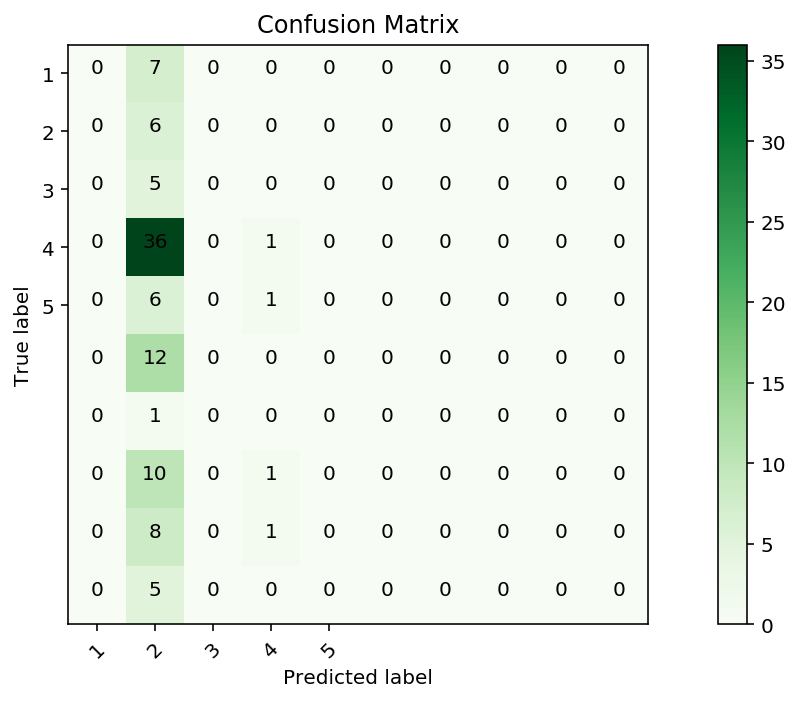

In [38]:
import itertools
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

cm = confusion_matrix(y_true=y_true, y_pred=y_pred)

plt.figure()
fig, ax = plt.subplots(figsize=(10,5))
plot_conf_mat(cm, 
              classes=['1', '2', '3', '4', '5'], 
              title='Confusion Matrix')
plt.show()